In [0]:
from google.colab import auth, drive

auth.authenticate_user()

In [0]:
!earthengine authenticate

In [0]:
# Import the Earth Engine API and initialize it.
import ee
import time
import os
import random as rn
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%tensorflow_version 1.x
import tensorflow as tf

# Fijar semillas para reproducibilidad de resultados (antes de importar Keras)
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)

import keras
from keras.optimizers import adam
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

# Montamos la unidad de trabajo de nuestro drive
drive.mount('/content/drive/')

# Cambiamos la ruta de trabajo a nuestro drive
os.chdir('/content/drive/My Drive/')

ee.Initialize()

Funciones a utilizar

In [0]:
# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask).select(bands).divide(10000)


def normalizedDifference(a, b):
  """Compute normalized difference of two inputs.

  Compute (a - b) / (a + b).  If the denomenator is zero, add a small delta.  

  Args:
    a: B5 value
    b: B4 value

  Returns:
    The normalized difference.
  """
  nd = (a - b) / (a + b)
  nd_inf = (a - b) / (a + b + 0.000001)

  if np.isinf(nd):
    return nd
  else:
    return nd_inf

# When the network has finished the training, all the generated models will be erased, unless the three best models.
def cleanExperimentFolder(folderNameExperimentPath):

  models = os.listdir(folderNameExperimentPath)
  models.sort(reverse=True)

  # We check if there is, at least, three min model saved
  if len(models) > 3:
    for i in range (3,len(models)):
      model_path = os.path.join(folderNameExperimentPath,models[i])
      os.remove(model_path)
      print("Experiment %s removed" %(model_path))
  else:
    print("Folder %s ignored" %(folderNameExperimentPath))

def plot_history(history):

  plt.figure(figsize=(8, 5))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.yscale('log')
  plt.plot(history.epoch,np.array(history.history['loss']),label='categorical_crossentropy (training)')
  plt.plot(history.epoch,np.array(history.history['val_loss']),label='categorical_crossentropy (validation)')
  plt.legend()

  max_y = max(max(np.array(history.history['loss'])), max(np.array(history.history['val_loss'])))

def addNDVI(numpy_array):

  """Add NDVI to the dataset.
  Args: 
    features: a dictionary of input tensors keyed by feature name.
    label: the target label
  
  Returns:
    A numpy array with an NDVI added.
  """
  ndvi_array = []
  tam = numpy_array.shape[0]

  for i in range(0,tam):
    ndvi_array.append([normalizedDifference(numpy_array[i,3],numpy_array[i,2])])

  return np.append(numpy_array,ndvi_array, axis=1)


Ejemplo 1.1 - Preprocesar datos de Earth Engine y obtener las tablas en CSV.

In [0]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
label = 'landcover'

# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
# The image input data is a 2018 cloud-masked median composite.
image = l8sr.filterDate('2018-01-01', '2018-12-31').map(maskL8sr).median()

# Change the following two lines to use your own training data.
labels = ee.FeatureCollection('GOOGLE/EE/DEMOS/demo_landcover_labels')

# Sample the image at the points and add a random column.
sample = image.sampleRegions(collection=labels, properties=[label], scale=30).randomColumn()

# Partition the sample approximately 70-30.
training = sample.filter(ee.Filter.lt('random', 0.7))
testing = sample.filter(ee.Filter.gte('random', 0.7))

# Names for output files.
trainFilePrefix = 'Training_demo'
testFilePrefix = 'Testing_demo'
fileNameSuffix = '.csv'

# This is list of all the properties we want to export.
featureNames = list(bands)
featureNames.append(label)

trainingTask = ee.batch.Export.table.toDrive(
    collection=training,
    folder='agricultura',
    description='Training Export', 
    fileNamePrefix=trainFilePrefix, 
    fileFormat='CSV',
    selectors=featureNames)

testingTask = ee.batch.Export.table.toDrive(
    collection=testing,
    folder='agricultura',
    description='Testing Export', 
    fileNamePrefix=testFilePrefix, 
    fileFormat='CSV',
    selectors=featureNames)

# Start the tasks.
trainingTask.start()
testingTask.start()

# Poll the training task until it's done.
while trainingTask.active():
  print('Polling for task (id: {}).'.format(trainingTask.id))
  time.sleep(30)
print('Done with training export.')

# Poll the testing task until it's done.
while testingTask.active():
  print('Polling for task (id: {}).'.format(testingTask.id))
  time.sleep(30)
print('Done with testing export.')

Ejemplo 1.2 - Obtener el fichero csv y prepararlo para keras

In [0]:
# Get the csv tables from Google drive
trainFilePath = 'agricultura/tables/' + trainFilePrefix + fileNameSuffix
testFilePath = 'agricultura/tables/' + testFilePrefix + fileNameSuffix

# Get the dataframes
trainDataFrame = pd.read_csv(trainFilePath)
print('csv for training loaded')
testDataFrame = pd.read_csv(testFilePath)
print('csv for testing loaded')

# Get a numpy array of the dataframe
train_n = trainDataFrame.to_numpy()
test_n = testDataFrame.to_numpy()

np.random.shuffle(train_n)
np.random.shuffle(test_n)

x_train = train_n[:,:-1]
y_train = train_n[:,-1]

x_test = test_n[:,:-1]
y_test = test_n[:,-1]

# Get the x_val and y_val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2) # 80% train, 20% val

num_classes = 3

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Add NDVI
x_train = addNDVI(x_train)
x_test = addNDVI(x_test)
x_val = addNDVI(x_val)

Ejemplo 1.3 - Crear el modelo y empezar a entrenar

In [0]:
# Number of features
num_features_input = x_train.shape[1]

# hyperparameters
lr = 1e-03
batch_size = 16
epochs = 80
shuffle = True
percentageDropout = 0.2
HiddenLayers = 2
HiddenNeurons = [4,4]
loss_function = 'categorical_crossentropy'
metrics = 'accuracy'

# Experiment folder and name
nameExperimentsFolder = 'experiments'
nameExperiment = 'land_classification'
nameModel = 'lr%.1e-bs%d-drop%.2f-hla%d-hne%s' % (lr,batch_size,percentageDropout,HiddenLayers,str(HiddenNeurons))
fileExtension = '{epoch:02d}-{val_loss:.4f}.hdf5'

# Create the folder of experiments where we will save the models
if not(os.path.exists(os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel))):
  os.makedirs(os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel))

# Callback parameters
monitor_stop = 'acc' # What the model will check in order to stop the training
monitor_reduce_lr = 'loss' # What the model will check in order to change the learning rate
min_delta = 1e-03 # Minimum change in the monitored quantity to qualify as an improvement
patience_stop = 50 # Number of epochs with no improvement after which training will be stopped.
patience_reduce_lr = 8 # Number of epochs with no improvement after which lr will be reduced.

callbacks = []
callbacks.append(ModelCheckpoint(os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel,fileExtension),
                                 monitor='val_loss', save_best_only=True, mode='min', verbose=1))
callbacks.append(TensorBoard(log_dir=os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel, 'logs'), 
                             write_graph=True))
#tbc=TensorBoardColab(graph_path=os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel,'Graph'))
#callbacks.append(TensorBoardColabCallback(tbc))
callbacks.append(EarlyStopping(monitor=monitor_stop, min_delta=min_delta, patience=patience_stop, verbose=1))
callbacks.append(ReduceLROnPlateau(monitor=monitor_reduce_lr, factor=0.1, patience=patience_reduce_lr, min_lr=1e-08))

# Create the model
model = Sequential()
model.add(Dense(64, activation=tf.nn.relu, input_dim=num_features_input))
model.add(Dropout(percentageDropout))
model.add(Dense(num_classes, activation='softmax'))

# Show the neural net
print(model.summary())

# Compiling the neural network
model.compile(
    optimizer=adam(lr=lr), 
    loss='categorical_crossentropy', 
    metrics =['accuracy'])

# Training the model
history = model.fit(
    x=x_train,
    validation_data=(x_val,y_val),
    y=y_train,
    batch_size=batch_size, 
    epochs=epochs, 
    shuffle=shuffle,
    callbacks=callbacks,
    verbose=1)

In [0]:
# Clean the folder where the models are saved
if os.path.exists(os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel)):
  cleanExperimentFolder(os.path.join('agricultura',nameExperimentsFolder,nameExperiment,nameModel))

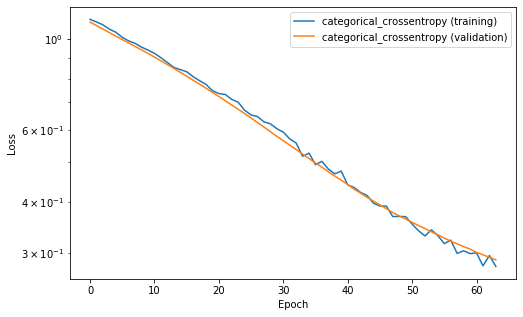

In [0]:
plot_history(history)

1.4 Evaluamos con los conjuntos de entrenamiento y de test

In [0]:
# Evaluate training data
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# Evaluate val data
score = model.evaluate(x_val, y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

# Evaluate test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


1.5 Imprimimos la matriz de confusión

In [0]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)

1.6 Mostramos las predicciones

In [0]:
labels = ['urban', 'vegetation', 'water']

predictions = model.predict(x_test)

for i in range(0,len(y_test)):
  print("land %d - Real: %s - Predicted: %s" % (i+1,labels[y_test[i].argmax()],labels[predictions[i].argmax()]))

In [0]:
#%load_ext tensorboard
#!tensorboard.version.VERSION

#%reload_ext tensorboard
#!tensorboard --logdir logs